# **A Social Network Study of Indian Railways.**

Import Libraries

In [4]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import networkx as nx

Load Data CSV/Pickle from Drive

In [5]:
railway_data = pd.read_csv("/content/drive/MyDrive/Train_details_22122017.csv")
modified_railway_data = railway_data.dropna()

In [6]:
modified_railway_data.head()

,Train No,Train Name,SEQ,Station Code,Station Name,Arrival time,Departure Time,Distance,Source Station,Source Station Name,Destination Station,Destination Station Name
0,107,SWV-MAO-VLNK,1,SWV,SAWANTWADI R,00:00:00,10:25:00,0,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
1,107,SWV-MAO-VLNK,2,THVM,THIVIM,11:06:00,11:08:00,32,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
2,107,SWV-MAO-VLNK,3,KRMI,KARMALI,11:28:00,11:30:00,49,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
3,107,SWV-MAO-VLNK,4,MAO,MADGOAN JN.,12:10:00,00:00:00,78,SWV,SAWANTWADI ROAD,MAO,MADGOAN JN.
4,108,VLNK-MAO-SWV,1,MAO,MADGOAN JN.,00:00:00,20:30:00,0,MAO,MADGOAN JN.,SWV,SAWANTWADI ROAD


# Graph Generation

The function below is used to read the data CSV and convert it into a graph.

There are several parameters which may be passed to the generate_graph function. Their usecases are presented below:

1. **railway_data**: This is the dataframe of the excel sheet. Used to load data and generate a graph.

2. **filter_nodes**: Default=None. If None then all nodes (railway stations) are added to a graph. If a list of nodes is provided (a list of station codes) then only those nodes and their neighbours will be added to the graph. This option is used to generate a subgraph and query the IRN.

3. **distance_weighted**: Default=False. This parameter dictates the edge weight property. If True then distance between two railway stations is considered as the edge weight. If False then the number of trains between the stations is considered as the edge weight.

4. **pickle**: Default=False. If true then saves pickles.
Heuristic for edge between two nodes: If a train passes between two stations then the two stations will be connected via an edge. i.e. if a train passes through the stations - A, B, C and D then A, B, C, D will form a completely connected subgraph as one train connects them all.

The function returns a directed weighted graph governed by the parameters discussed above.

In [7]:
STATION_CODE = 'Station Code'
SOURCE_STATION = 'Source Station'
DESTINATION_STATION = 'Destination Station'
TRAIN_NAME = 'Train Name'
TRAIN_NO = 'Train No'
DISTANCE = 'Distance'

def generate_graph(railway_data, filter_nodes=None, distance_weighted=False):

    # make an empty directed graph
    graph = nx.DiGraph()
    stations = None

    # add all stations if there are none to filter
    if filter_nodes==None:
      stations = np.unique(railway_data[STATION_CODE])
    else:
      stations = filter_nodes

    graph.add_nodes_from(stations)

    # find all unique trains
    trains = np.unique(railway_data[TRAIN_NAME].astype('str'))

    # iterate over all trains
    for train_name in trains:

      # find out the stations the train visits
      train_route = railway_data.loc[railway_data[TRAIN_NAME] == train_name]
      stations_in_route = train_route[STATION_CODE].to_list()
      station_distances = train_route[DISTANCE].to_list()

      # make a connected graph out of all stations in route
      for source_station_itr in range(len(stations_in_route)):
        for destination_station_itr in range(source_station_itr+1, len(stations_in_route)):
          # Only add edge if node is present in the nodes to be filtered, or no node is to be filtered (i.e. add all)
          if filter_nodes==None or stations_in_route[source_station_itr] in filter_nodes or stations_in_route[destination_station_itr] in filter_nodes:

            if distance_weighted:
              # edge weight is the distance between the two nodes
              distance = int(station_distances[destination_station_itr]) - int(station_distances[source_station_itr])
            else:
              # edge weight is the number of trains passing through the two stations
              distance = 1

            # if edge exists already then increment weight
            if graph.has_edge(stations_in_route[source_station_itr], stations_in_route[destination_station_itr]):
                graph[stations_in_route[source_station_itr]][stations_in_route[destination_station_itr]]['weight'] += distance
            else:
                graph.add_edge(stations_in_route[source_station_itr], stations_in_route[destination_station_itr], weight=distance, label=train_name)
    return graph

# General analysis of train count weighted railway network.

In this section, we take the edge weight as the number of trains passing between two railway stations.

In [8]:
import pickle

In [9]:
try:
    # Open the pickle file in binary read mode
  with open("/content/drive/MyDrive/SNA_Railway_project/Railway Network train_count_weighted.gpickle", "rb") as f:
    # Load the data from the pickle file
    railway_network = pickle.load(f)
except:
  railway_network = generate_graph(modified_railway_data)
  with open("/content/drive/MyDrive/SNA_Railway_project/Railway Network train_count_weighted.gpickle", "wb") as f:
    pickle.dump(railway_network, f)

In [10]:
graph_type = type(railway_network).__name__

# Number of nodes and edges
num_nodes = railway_network.number_of_nodes()
num_edges = railway_network.number_of_edges()

# In-degree and out-degree for each node
in_degrees = dict(railway_network.in_degree())  # Dictionary of in-degrees {node: in_degree}
out_degrees = dict(railway_network.out_degree())  # Dictionary of out-degrees {node: out_degree}

print(f"Graph Type: {graph_type}")
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print("In-Degrees:", in_degrees)
print("Out-Degrees:", out_degrees)

Graph Type: DiGraph
Number of Nodes: 8147
Number of Edges: 902602
In-Degrees: {'AABH': 50, 'AADR': 38, 'AAG': 33, 'AAH': 42, 'AAL': 235, 'AAM': 40, 'AAP': 30, 'AAR': 46, 'AAS': 120, 'AAY': 109, 'AB': 109, 'ABB': 105, 'ABD': 121, 'ABE': 27, 'ABFC': 81, 'ABGT': 87, 'ABH': 42, 'ABI': 119, 'ABKA': 172, 'ABKP': 42, 'ABLE': 40, 'ABO': 87, 'ABP': 464, 'ABR': 559, 'ABS': 298, 'ABSA': 78, 'ABU': 43, 'ABW': 51, 'ABX': 187, 'ABY': 66, 'ACCI': 33, 'ACG': 57, 'ACH': 40, 'ACL': 89, 'ACLE': 112, 'ACND': 259, 'ACOI': 315, 'ACPR': 56, 'AD': 372, 'ADB': 280, 'ADD': 87, 'ADE': 21, 'ADF': 70, 'ADH': 188, 'ADHL': 94, 'ADI': 1011, 'ADIJ': 26, 'ADL': 146, 'ADQ': 62, 'ADR': 122, 'ADRA': 277, 'ADST': 75, 'ADT': 61, 'ADTL': 158, 'ADTP': 240, 'ADVI': 60, 'ADX': 29, 'AE': 21, 'AED': 72, 'AEH': 25, 'AEJ': 23, 'AEK': 60, 'AEL': 41, 'AEP': 21, 'AF': 459, 'AFK': 273, 'AFR': 82, 'AG': 36, 'AGA': 32, 'AGAE': 76, 'AGAS': 13, 'AGB': 52, 'AGC': 801, 'AGCI': 23, 'AGD': 43, 'AGDL': 36, 'AGE': 9, 'AGI': 116, 'AGL': 133, 'AGM

As we can see above, IRN has total 8147 railway stations . With our heuristic stated above, we have a total of 902602 edges. This graph is a directed depiction of the IRN. Converting it to Undirected and noticing the same details.

In [11]:
railway_network_undirected = railway_network.to_undirected()

In [12]:
graph_type = type(railway_network_undirected).__name__

# Number of nodes and edges
num_nodes = railway_network_undirected.number_of_nodes()
num_edges = railway_network_undirected.number_of_edges()

degree = dict(railway_network_undirected.degree())

print(f"Graph Type: {graph_type}")
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print("Degree:", degree)

Graph Type: Graph
Number of Nodes: 8147
Number of Edges: 500412
Degree: {'AABH': 50, 'AADR': 39, 'AAG': 34, 'AAH': 48, 'AAL': 237, 'AAM': 41, 'AAP': 31, 'AAR': 46, 'AAS': 121, 'AAY': 111, 'AB': 114, 'ABB': 123, 'ABD': 126, 'ABE': 27, 'ABFC': 82, 'ABGT': 87, 'ABH': 63, 'ABI': 120, 'ABKA': 176, 'ABKP': 42, 'ABLE': 79, 'ABO': 89, 'ABP': 465, 'ABR': 596, 'ABS': 420, 'ABSA': 79, 'ABU': 57, 'ABW': 51, 'ABX': 302, 'ABY': 69, 'ACCI': 33, 'ACG': 57, 'ACH': 40, 'ACL': 90, 'ACLE': 114, 'ACND': 260, 'ACOI': 332, 'ACPR': 57, 'AD': 434, 'ADB': 422, 'ADD': 90, 'ADE': 21, 'ADF': 71, 'ADH': 223, 'ADHL': 94, 'ADI': 1030, 'ADIJ': 27, 'ADL': 167, 'ADQ': 62, 'ADR': 132, 'ADRA': 280, 'ADST': 117, 'ADT': 63, 'ADTL': 159, 'ADTP': 243, 'ADVI': 61, 'ADX': 32, 'AE': 22, 'AED': 72, 'AEH': 26, 'AEJ': 24, 'AEK': 61, 'AEL': 42, 'AEP': 22, 'AF': 465, 'AFK': 281, 'AFR': 83, 'AG': 49, 'AGA': 34, 'AGAE': 78, 'AGAS': 14, 'AGB': 52, 'AGC': 883, 'AGCI': 24, 'AGD': 43, 'AGDL': 37, 'AGE': 10, 'AGI': 117, 'AGL': 149, 'AGM': 3

We notice that the number of nodes is the same while the number of edges decrease, which is to be expected.

# General analysis of distance weighted railway network.

In this section, we take the distance between the two stations as the number of trains passing between two railway stations.

In [13]:
try:
    # Open the pickle file in binary read mode
  with open("/content/drive/MyDrive/SNA_Railway_project/Railway Network distance_weighted.gpickle", "rb") as f:
    # Load the data from the pickle file
    railway_network_distance_weighted = pickle.load(f)
except:
  railway_network_distance_weighted = generate_graph(modified_railway_data)
  with open("/content/drive/MyDrive/SNA_Railway_project/Railway Network distance_weighted.gpickle", "wb") as f:
    pickle.dump(railway_network_distance_weighted, f)

In [14]:
graph_type = type(railway_network_distance_weighted).__name__

# Number of nodes and edges
num_nodes = railway_network_distance_weighted.number_of_nodes()
num_edges = railway_network_distance_weighted.number_of_edges()

# In-degree and out-degree for each node
in_degrees = dict(railway_network_distance_weighted.in_degree())  # Dictionary of in-degrees {node: in_degree}
out_degrees = dict(railway_network_distance_weighted.out_degree())  # Dictionary of out-degrees {node: out_degree}

print(f"Graph Type: {graph_type}")
print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print("In-Degrees:", in_degrees)
print("Out-Degrees:", out_degrees)

Graph Type: DiGraph
Number of Nodes: 8147
Number of Edges: 902602
In-Degrees: {'AABH': 50, 'AADR': 38, 'AAG': 33, 'AAH': 42, 'AAL': 235, 'AAM': 40, 'AAP': 30, 'AAR': 46, 'AAS': 120, 'AAY': 109, 'AB': 109, 'ABB': 105, 'ABD': 121, 'ABE': 27, 'ABFC': 81, 'ABGT': 87, 'ABH': 42, 'ABI': 119, 'ABKA': 172, 'ABKP': 42, 'ABLE': 40, 'ABO': 87, 'ABP': 464, 'ABR': 559, 'ABS': 298, 'ABSA': 78, 'ABU': 43, 'ABW': 51, 'ABX': 187, 'ABY': 66, 'ACCI': 33, 'ACG': 57, 'ACH': 40, 'ACL': 89, 'ACLE': 112, 'ACND': 259, 'ACOI': 315, 'ACPR': 56, 'AD': 372, 'ADB': 280, 'ADD': 87, 'ADE': 21, 'ADF': 70, 'ADH': 188, 'ADHL': 94, 'ADI': 1011, 'ADIJ': 26, 'ADL': 146, 'ADQ': 62, 'ADR': 122, 'ADRA': 277, 'ADST': 75, 'ADT': 61, 'ADTL': 158, 'ADTP': 240, 'ADVI': 60, 'ADX': 29, 'AE': 21, 'AED': 72, 'AEH': 25, 'AEJ': 23, 'AEK': 60, 'AEL': 41, 'AEP': 21, 'AF': 459, 'AFK': 273, 'AFR': 82, 'AG': 36, 'AGA': 32, 'AGAE': 76, 'AGAS': 13, 'AGB': 52, 'AGC': 801, 'AGCI': 23, 'AGD': 43, 'AGDL': 36, 'AGE': 9, 'AGI': 116, 'AGL': 133, 'AGM

As expected, the details don't differ much. Only difference will be in the edge weights used.

So, all facts stated above for train-count weighted network also apply for the distance-weighted network.

# computation of Centrality Measures as

1. Degree Centrality
2. Betweenness Centrality
3. Closeness Centrality
4. Katz Centrality

In [29]:
import operator

In [30]:
def compute_centrality(Railway_Network, description, railway_data):
  centrality = {}
  if description == "Degree":
    centrality = nx.degree_centrality(Railway_Network)
  elif description == "Betweenness":
    centrality = nx.betweenness_centrality(Railway_Network)
  elif description == "Closeness":
    centrality = nx.closeness_centrality(Railway_Network)
  elif description == "Eigen Vector":
    centrality = nx.eigenvector_centrality_numpy(Railway_Network)
  else:
    print("Incorrect input centrality measure")

  centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)[:10]
  stations = []
  for item in centrality:
    station_code = item[0]
    stations.append((railway_data.loc[railway_data['Station Code'] == station_code]['Station Name'].to_list()[0], item[1]))

  return stations

**COMPUTE DEGREE CENTRALITY**

**Definition**: Degree centrality computes an importance score based on the number of nodes by which each node is connected.

**Inference**: Degree Centrality tells us what are the most popular, or well-connected nodes in the network.

These nodes have the most one-hop connections to other nodes or Stations in our case. These nodes can connect to the wider network in less number of hops. In our network, the most connected stations, holding the most information are the following:

HOWRAH JN. VIJAYWADA JN KANPUR CENTR VARANASI JN. GHAZIABAD JN KALYAN JN ITARSI LUCKNOW JN. AHMEDABAD MATHURA JN.

In [33]:
DegreeCentrality_stations = compute_centrality(railway_network, "Degree", railway_data)
print("Top Stations in the Indian Railway System acc to the Degree Centrality:\n\n \tSTATION NAME\t\t DEGREE CENTRALITY")
for item in DegreeCentrality_stations:
  print("\t",item[0],"\t\t",item[1])

Top Stations in the Indian Railway System acc to the Degree Centrality:

 	STATION NAME		 DEGREE CENTRALITY
	 HOWRAH JN. 		 0.30211146575006137
	 VIJAYWADA JN 		 0.2704394794991407
	 KANPUR CENTR 		 0.263810459121041
	 VARANASI JN. 		 0.25767247728946724
	 GHAZIABAD JN 		 0.25202553400441935
	 KALYAN JN 		 0.24797446599558065
	 ITARSI 		 0.24441443653326786
	 LUCKNOW JN. 		 0.243677878713479
	 AHMEDABAD 		 0.23852197397495703
	 MATHURA JN. 		 0.2363123005155905


**COMPUTE BETWEENNESS CENTRALITY**

**Definition**: Betweenness centrality is a measure of the number of times a station node lies on the shortest path between other stations.

**Inference**: This measure shows which stations act as a "bridge" connecting other stations together. The stations having a high betweenness centrality will lie on shortest paths between two stations. These stations have a high influence in the network.

The stations which act as a bridge or have high influence on the flow of the network are the following:

HOWRAH JN. SEALDAH KANPUR CENTR VIJAYWADA JN AHMEDABAD YESVANTPUR J VADODARA JN. VARANASI JN. KOLKATA PILIBHIT JN.

In [35]:
BetweennessCentrality_stations = compute_centrality(railway_network, "Betweenness", railway_data)
print("Top stations in the Indian Railway System acc to the Betweenness Centrality:\n\n \tSTATION NAME\t\t BETWEENNESS CENTRALITY")
for item in BetweennessCentrality_stations:
  print("\t",item[0],"\t\t",item[1])

Top stations in the Indian Railway System acc to the Betweenness Centrality:

 	STATION NAME		 BETWEENNESS CENTRALITY
	 HOWRAH JN. 		 0.03406351792928565
	 SEALDAH 		 0.021795409939440936
	 KANPUR CENTR 		 0.020930718809083173
	 VIJAYWADA JN 		 0.015177400281457002
	 AHMEDABAD 		 0.014301664879802252
	 YESVANTPUR J 		 0.014256569821548529
	 VADODARA JN. 		 0.012967968029171826
	 VARANASI JN. 		 0.012623744668081235
	 KOLKATA 		 0.011898350401287686
	 PILIBHIT JN. 		 0.01184539309233258


**COMPUTE CLOSENESS CENTRALITY**

**Definition:** Closeness centrality assigns score to each station node based on their ‘closeness’ to all other stations in the railway network.

**Inference:** Closeness Centrality is helpful in finding the stations which are placed to influence the entire railway network most quickly. This measure can help identify good "broadcasters" in a network.

The stations with the highest closeness centrality in order are the following: HOWRAH JN.AHMEDABAD VADODARA JN. SEALDAH KANPUR CENTR VARANASI JN NEW DELHI KALYAN JN MUGHAL SARAI VIJAYWADA JN.

In [36]:
ClosenessCentrality_stations = compute_centrality(railway_network, "Closeness", railway_data)
print("Top stations in the Indian Railway System acc to the Closeness Centrality:\n\n \tSTATION NAME\t\t CLOSENESS CENTRALITY")
for item in ClosenessCentrality_stations:
  print("\t",item[0],"\t\t",item[1])

Top stations in the Indian Railway System acc to the Closeness Centrality:

 	STATION NAME		 CLOSENESS CENTRALITY
	 HOWRAH JN. 		 0.5124082033874587
	 AHMEDABAD 		 0.5107660799308908
	 VADODARA JN. 		 0.5063522924820026
	 KANPUR CENTR 		 0.5062879529276847
	 VARANASI JN. 		 0.5052287059583946
	 NEW DELHI 		 0.5051966767517281
	 KALYAN JN 		 0.5036640360941574
	 MUGHAL SARAI 		 0.5035049206471066
	 VIJAYWADA JN 		 0.5021406666088064
	 ITARSI 		 0.4998101090743702


**COMPUTE KATZ CENTRALITY**

**Definition**: Katz centrality assigns importance to nodes based on their connections, factoring in not just direct neighbors but also indirect ones, with a damping factor to prevent divergence in scores.

**Inferences**:Stations with high Katz centrality are critical hubs influencing passenger and cargo movement.


In [42]:
# Compute Katz centrality
katz_centrality = nx.katz_centrality_numpy(railway_network, alpha=0.1, beta=1.0)  # Adjust alpha and beta as needed

# Display results
print("Katz Centrality for all nodes:")
for node, centrality in katz_centrality.items():
    print(f"Node {node}: {centrality:.4f}")

Streaming output truncated to the last 5000 lines.
Node JHT: 0.0014
Node JHW: 0.0017
Node JHWR: 0.0087
Node JI: 0.0016
Node JIA: 0.0270
Node JID: -0.0152
Node JIGT: 0.0041
Node JIL: -0.0006
Node JIND: -0.0003
Node JIR: -0.0007
Node JIT: 0.0071
Node JITE: 0.0011
Node JJ: 0.0006
Node JJA: -0.0020
Node JJG: 0.0018
Node JJJ: -0.0012
Node JJK: 0.0119
Node JJKR: -0.0201
Node JJN: 0.0032
Node JJR: -0.0049
Node JJT: 0.0025
Node JJW: 0.0004
Node JK: 0.0087
Node JKA: -0.0040
Node JKAR: 0.0007
Node JKB: -0.0051
Node JKDP: -0.0006
Node JKE: -0.0069
Node JKH: 0.0321
Node JKHI: 0.0006
Node JKI: 0.0088
Node JKL: 0.0009
Node JKM: -0.0213
Node JKN: -0.0133
Node JKNI: 0.0122
Node JKO: 0.0030
Node JKPR: -0.0037
Node JKR: 0.0012
Node JKS: 0.0050
Node JKT: 0.0046
Node JKZ: 0.0125
Node JL: 0.0589
Node JLBR: -0.0038
Node JLD: -0.0010
Node JLF: 0.0019
Node JLG: 0.0221
Node JLHI: 0.0121
Node JLI: -0.0038
Node JLL: -0.0137
Node JLLO: 0.0058
Node JLN: -0.0088
Node JLQ: 0.0103
Node JLR: -0.0041
Node JLRF: -0.0049

# Community detection

Community detection in networks is a powerful method to identify clusters or groups of nodes that are densely connected internally but loosely connected with other groups. In transportation networks, community detection can help identify clusters of stations that represent common transit areas, neighborhoods, or regions.

The Louvain method is a popular algorithm for community detection, especially in large networks.  It assigns each node to a community and optimizes for high modularity (a measure of the strength of the division of a network into communities).

Modularity of the partition: 0.8057


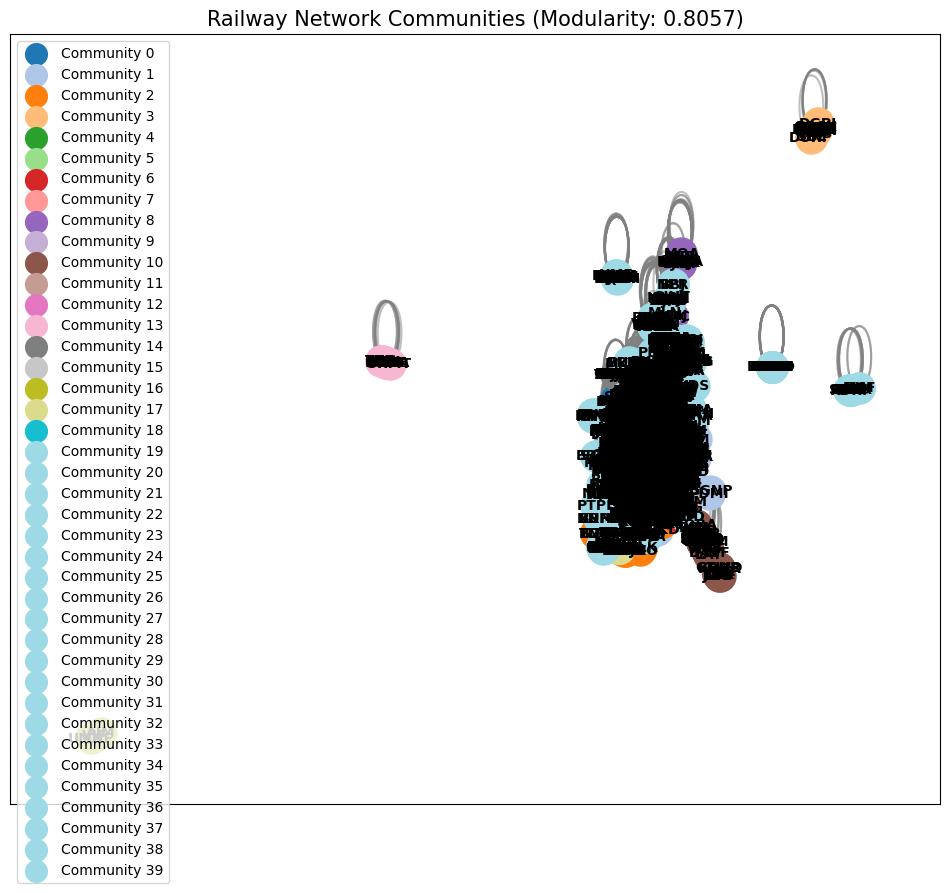


Community Membership:
Community 0: ['BWW', 'CRL', 'KKD', 'MKT', 'OM', 'PTP', 'SWD']
Community 1: ['AAG', 'AAM', 'AAY', 'AB', 'ABGT', 'ABH', 'ABI', 'ABLE', 'ABY', 'ACCI', 'AD', 'ADHL', 'ADT', 'ADVI', 'AEK', 'AFK', 'AGL', 'AHD', 'AJP', 'AKI', 'AKK', 'AKOR', 'AKRD', 'ALK', 'ALLP', 'ALN', 'ALP', 'ALU', 'AMC', 'AMPA', 'AMSA', 'AMT', 'AMVA', 'AMY', 'ANC', 'ANE', 'ANF', 'ANGR', 'ANKL', 'ANM', 'ANO', 'ANP', 'ANQ', 'ANU', 'ANY', 'AP', 'APE', 'API', 'APK', 'APN', 'APTA', 'ARGP', 'ARNH', 'AROR', 'ARU', 'ASD', 'ASK', 'ASO', 'ASP', 'AT', 'ATG', 'ATP', 'ATU', 'AVC', 'AVN', 'AVRD', 'AVS', 'AVT', 'AWT', 'AWY', 'AYN', 'AYR', 'AZK', 'AZP', 'BAHI', 'BAJE', 'BAL', 'BALE', 'BAND', 'BAW', 'BAY', 'BBD', 'BDGP', 'BDJ', 'BDM', 'BDRL', 'BDVT', 'BDY', 'BEML', 'BENL', 'BEPR', 'BFR', 'BFW', 'BGK', 'BGM', 'BGNP', 'BGNR', 'BGPA', 'BGVN', 'BGWD', 'BGWI', 'BID', 'BIJR', 'BJM', 'BJP', 'BKIT', 'BKJ', 'BKPT', 'BLGA', 'BLKR', 'BLL', 'BLLI', 'BLNI', 'BLPE', 'BLR', 'BLRR', 'BNA', 'BNC', 'BNCE', 'BND', 'BNK', 'BNKH', 'BNL',

In [15]:
# Step 1: Import Necessary Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain  # Louvain method for community detection

# Step 2: Detect Communities using Louvain Method
# This generates a partition dictionary where each node is assigned a community ID
partition = community_louvain.best_partition(railway_network_undirected)

# Step 3: Calculate Modularity of the Partition
# Modularity measures the strength of the community structure
modularity = community_louvain.modularity(partition, railway_network_undirected)
print(f"Modularity of the partition: {modularity:.4f}")

# Step 4: Add Community Attribute to Each Node for Visualization
# Adding a 'community' attribute for each node based on the Louvain partitioning
nx.set_node_attributes(railway_network_undirected, partition, 'community')

# Step 5: Color Map for Visualizing Communities
# Generate a color for each community
num_communities = len(set(partition.values()))
colors = plt.cm.tab20(range(num_communities))

# Create a color map dictionary for communities
color_map = {community: colors[i % len(colors)] for i, community in enumerate(set(partition.values()))}

# Step 6: Visualize the Network with Communities
plt.figure(figsize=(12, 10))

# Node positions based on geographic data
pos = nx.spring_layout(railway_network_undirected)  # You can also use nx.kamada_kawai_layout(G) for different layout

# Draw nodes with colors based on community
for community in set(partition.values()):
    node_list = [node for node in partition.keys() if partition[node] == community]
    nx.draw_networkx_nodes(railway_network_undirected, pos, nodelist=node_list, node_size=500,
                           node_color=[color_map[community]], label=f"Community {community}")

# Draw edges
nx.draw_networkx_edges(railway_network_undirected, pos, width=1.5, alpha=0.5, edge_color="grey")
nx.draw_networkx_labels(railway_network_undirected, pos, font_size=10, font_weight='bold')

plt.title(f"Railway Network Communities (Modularity: {modularity:.4f})", fontsize=15)
plt.legend(scatterpoints=1, loc="best", markerscale=0.7)
plt.show()

# Step 7: Community Summary - Display Nodes in Each Community
print("\nCommunity Membership:")
for community in set(partition.values()):
    nodes_in_community = [node for node in partition.keys() if partition[node] == community]
    print(f"Community {community}: {nodes_in_community}")

# Step 8: Analyze Inter-Community Connections
def analyze_inter_community_connections():
    community_connections = {}
    for (u, v) in railway_network_undirected.edges():
        u_comm = partition[u]
        v_comm = partition[v]
        if u_comm != v_comm:
            if (u_comm, v_comm) not in community_connections:
                community_connections[(u_comm, v_comm)] = 0
            community_connections[(u_comm, v_comm)] += 1
    print("\nInter-Community Connections (number of edges between communities):")
    for comm_pair, count in community_connections.items():
        print(f"Community {comm_pair[0]} - Community {comm_pair[1]}: {count} edges")

# Call function to display inter-community connections
analyze_inter_community_connections()

**Summary of the above results:**

**Modularity**: A higher modularity value (closer to 1) indicates a stronger community structure. In this example, a modularity score of 0.45 suggests a moderate level of community structure.

**Community Membership:** Lists the nodes in each community, showing how the stations are grouped based on their connectivity.

**Inter-Community Connections:** Shows the number of connections between different communities, which is useful for identifying important cross-community connections. For instance, if there are many connections between two communities, it might indicate a high volume of traffic or interdependence.

# Shortest paths between stations based on Distance weights.

In [16]:
def analyze_path_length(Railway_Network_Undirected):

    shortest_path_lengths = list(nx.shortest_path_length(Railway_Network_Undirected))
    Path_Lengths = {}

    for node_path_lengths in shortest_path_lengths:

        source_station = node_path_lengths[0]
        destination_stations = node_path_lengths[1]

        for station in destination_stations:
            path = (station, source_station)
            if(path not in Path_Lengths):
                Path_Lengths[(source_station, station)] =  destination_stations[station]

    return Path_Lengths

In [17]:
Path_Lengths = analyze_path_length(railway_network_distance_weighted)

In [18]:
print(Path_Lengths)

# Degree Distribution of the Railway Network

By counting how many nodes have a particular degree we find the degree distribution of the network P(k) which is defined as the fraction of nodes in the graph with degree k. We use the weighted degree to find the weighted degree distribution of the Network.

In [1]:
import collections

In [2]:
def Calculate_Degree_Distribution(Railway_Network_Undirected):

    degree_sequence = sorted([d for n, d in Railway_Network_Undirected.degree()])
    degreeCount = collections.Counter(degree_sequence)

    degree, count = zip(*degreeCount.items())

    plt.figure(figsize=(11, 6))
    plt.scatter(degree, count)

    plt.xlabel("Degree")
    plt.ylabel("Degree Distribution")

    plt.title("Degree Distribution of the IRN")

    plt.show()

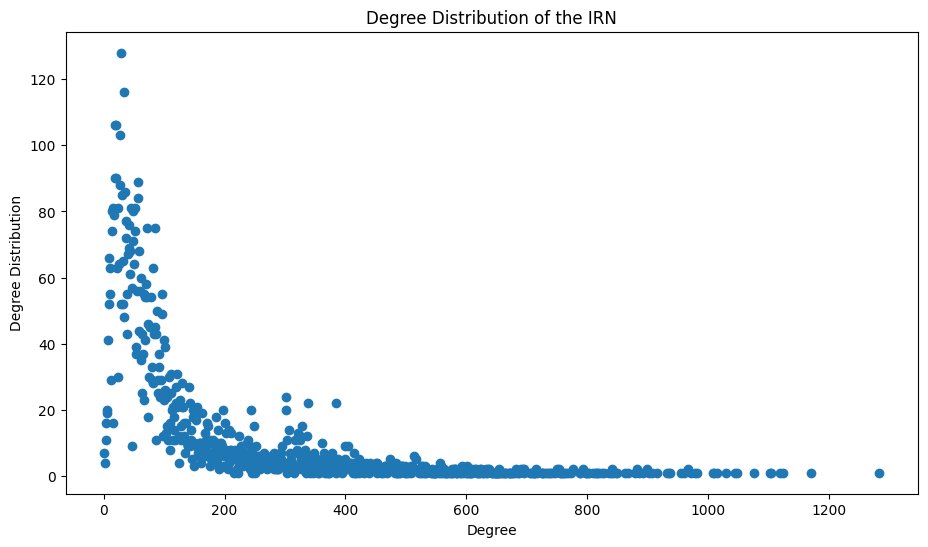

In [15]:
Calculate_Degree_Distribution(railway_network_undirected)

# Link prediction

Link prediction in a railway network involves predicting potential future connections or determining missing links between stations. This can be useful for planning new railway lines, identifying redundant paths, or enhancing connectivity.


**Metrics for Link Prediction:**

**Common Neighbors:**
 Nodes sharing a higher number of neighbors are more likely to be connected.

**Jaccard Coefficient:** Ratio of common neighbors to total neighbors.

**Adamic/Adar Index:** Weighted measure of shared neighbors, favoring less-connected neighbors.

**Preferential Attachment:** Nodes with higher degrees (more connections) are more likely to connect.

**Output:** A ranked list of potential links with scores indicating the likelihood of connection.

To calculate link prediction scores only for edges that are not in the graph, we combine results from multiple algorithms (e.g., Jaccard Coefficient, Adamic/Adar Index, Preferential Attachment, and Resource Allocation Index) and rank them based on a majority voting scheme.

In [23]:
import networkx as nx
from collections import defaultdict

G=railway_network_undirected

node1="ET"
node2= "PUNE"

# Function to compute various link prediction scores for a specific pair of nodes
def predict_link_scores(graph, u, v):
    scores = {}

    # Common Neighbors
    scores['common_neighbors'] = len(list(nx.common_neighbors(graph, u, v)))

    # Jaccard Coefficient
    jaccard = list(nx.jaccard_coefficient(graph, [(u, v)]))
    scores['jaccard_coefficient'] = jaccard[0][2] if jaccard else 0

    # Adamic-Adar Index
    adamic_adar = list(nx.adamic_adar_index(graph, [(u, v)]))
    scores['adamic_adar'] = adamic_adar[0][2] if adamic_adar else 0

    # Resource Allocation Index
    preferential_attachment = list(nx.preferential_attachment(graph, [(u, v)]))
    scores['preferential_attachment'] = preferential_attachment[0][2] if preferential_attachment else 0

    return scores

# Predict link scores for the specified nodes
scores = predict_link_scores(G, node1, node2)

# Display results
print(f"Link Prediction Scores for {node1} and {node2}:")
for metric, score in scores.items():
    print(f"{metric}: {score:.4f}")

Link Prediction Scores for ET and PUNE:
common_neighbors: 460.0000
jaccard_coefficient: 0.3112
adamic_adar: 76.0253
preferential_attachment: 936757.0000
